In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from sklearn import preprocessing

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# UNSUPERVISED 'BIO' LEARNING ALGORITHM

# Define function that performs the unsupervised learning and returns weights
# that correspond to feature detectors.
# Uses cuda if available.
def get_unsupervised_weights(data, n_hidden, n_epochs, batch_size, learning_rate, precision, 
                             anti_hebbian_learning_strength, lebesgue_norm, rank):
    print("Starting unsupervised bio-plausible training")
    
    num_samples = data.shape[0]   # Number of samples/images.
    num_features = data.shape[1]  # Number of pixels for each sample/image.
    
    # Initialize weights to be values drawn from gaussian distribution.
    synapses = np.random.normal(mu, sigma, (n_hidden, num_features)).astype(np.float32)
    weights = torch.from_numpy(synapses).to(device)

    # The external loop runs over epochs
    for epoch in range(n_epochs):
        eps = learning_rate * (1 - epoch / n_epochs)

        # Scramble the images and values. So that when making a
        # mini batch, random values/images will be chosen on each iteration.
        random_permutation_samples = np.random.permutation(num_samples)
        shuffled_epoch_data = data[random_permutation_samples,:]

        # Internal loop runs over minibatches    
        for i in range(num_samples // batch_size):        
            # For every minibatch the overlap with the data (tot_input) is 
            # calculated for each data point and each hidden unit.
            mini_batch = shuffled_epoch_data[i*batch_size:(i+1)*batch_size,:].astype(np.float32)
            mini_batch = torch.from_numpy(mini_batch).to(device)           
            mini_batch = torch.transpose(mini_batch, 0, 1)

            sign = torch.sign(weights)            
            W = sign * torch.abs(weights) ** (lebesgue_norm - 1)    
            # https://stackoverflow.com/questions/44524901/how-to-do-product-of-matrices-in-pytorch
            tot_input_torch = torch.mm(W, mini_batch)

            # The sorted strengths of the activations are stored in y. 
            # The variable yl stores the activations of the post synaptic cells - 
            # it is denoted by g(Q) in Eq 3 of 'Unsupervised Learning by Competing Hidden Units', see also Eq 9 and Eq 10.        
            y_torch = torch.argsort(tot_input_torch, dim=0)            
            yl_torch = torch.zeros((n_hidden, batch_size), dtype = torch.float).to(device)
            yl_torch[y_torch[n_hidden-1,:], torch.arange(batch_size)] = 1.0
            yl_torch[y_torch[n_hidden-rank], torch.arange(batch_size)] = -anti_hebbian_learning_strength

            # The variable ds is the right hand side of Eq 3        
            xx_torch = torch.sum(yl_torch * tot_input_torch,1)  
            xx_torch = xx_torch.unsqueeze(1)                    
            xx_torch = xx_torch.repeat(1, num_features)
            ds_torch = torch.mm(yl_torch, torch.transpose(mini_batch, 0, 1)) - (xx_torch * weights)

            # Update weights
            # The weights are updated after each minibatch in a way so that the largest update 
            # is equal to the learning rate eps at that epoch.        
            nc_torch = torch.max(torch.abs(ds_torch))
            if nc_torch < precision: 
                nc_torch = precision            
            weights += eps*(ds_torch/nc_torch)

            #if (i+1) % 100 == 0:
            #    print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{num_samples // batch_size}]')

        print (f'Epoch [{epoch+1}/{n_epochs}]')
        
    print("Completed unsupervised bio-plausible training")
    return weights
    #return weights.cpu().numpy()


In [ ]:
M = torch.load('/cs/scratch/aa295/M_tensor_no_shuffle_1.pt')
print(M.shape)

M = np.transpose(M.cpu().numpy())
print(M.shape)

print("LOADED M")



In [ ]:
# TRY TO SEE IF M IS BEING CONSTRUCTED PROPERLY BY PLOTTING THE IMAGES AFTER M IS CONSTRUCTED

M_rgb = M[1]
print(M_rgb.shape)
#print(M_rgb)

M_rgb = M_rgb.reshape(32, 32, 3)
print(M_rgb.shape)

plt.imshow(M_rgb)
plt.show()
# print(M_rgb)

In [4]:
"""Load from /home/USER/data/cifar10 or elsewhere; download if missing."""

import tarfile
import os
from urllib.request import urlretrieve
import numpy as np


def cifar10(path=None):
    r"""Return (train_images, train_labels, test_images, test_labels).

    Args:
        path (str): Directory containing CIFAR-10. Default is
            /home/USER/data/cifar10 or C:\Users\USER\data\cifar10.
            Create if nonexistant. Download CIFAR-10 if missing.

    Returns:
        Tuple of (train_images, train_labels, test_images, test_labels), each
            a matrix. Rows are examples. Columns of images are pixel values,
            with the order (red -> blue -> green). Columns of labels are a
            onehot encoding of the correct class.
    """
    url = 'https://www.cs.toronto.edu/~kriz/'
    tar = 'cifar-10-binary.tar.gz'
    files = ['cifar-10-batches-bin/data_batch_1.bin',
             'cifar-10-batches-bin/data_batch_2.bin',
             'cifar-10-batches-bin/data_batch_3.bin',
             'cifar-10-batches-bin/data_batch_4.bin',
             'cifar-10-batches-bin/data_batch_5.bin',
             'cifar-10-batches-bin/test_batch.bin']

    if path is None:
        # Set path to /home/USER/data/mnist or C:\Users\USER\data\mnist
        path = os.path.join(os.path.expanduser('~'), 'data', 'cifar10')
    print(f'Looking for data at path: {path}')

    # Create path if it doesn't exist
    os.makedirs(path, exist_ok=True)

    # Download tarfile if missing
    if tar not in os.listdir(path):
        urlretrieve(''.join((url, tar)), os.path.join(path, tar))
        print("Downloaded %s to %s" % (tar, path))
    print(f'Done adding tar to: {path}')

    # Load data from tarfile
    with tarfile.open(os.path.join(path, tar)) as tar_object:
        print(f'Load data from tarfile: {path}')
        
        # Each file contains 10,000 color images and 10,000 labels
        fsize = 10000 * (32 * 32 * 3) + 10000

        # There are 6 files (5 train and 1 test)
        buffr = np.zeros(fsize * 6, dtype='uint8')

        # Get members of tar corresponding to data files
        # -- The tar contains README's and other extraneous stuff
        members = [file for file in tar_object if file.name in files]

        # Sort those members by name
        # -- Ensures we load train data in the proper order
        # -- Ensures that test data is the last file in the list
        members.sort(key=lambda member: member.name)

        # Extract data from members
        print(f'Extract data from members')
        for i, member in enumerate(members):
            # Get member as a file object
            f = tar_object.extractfile(member)
            # Read bytes from that file object into buffr
            buffr[i * fsize:(i + 1) * fsize] = np.frombuffer(f.read(), 'B')
        print(f'Done extract data from members')

    # Parse data from buffer
    # -- Examples are in chunks of 3,073 bytes
    # -- First byte of each chunk is the label
    # -- Next 32 * 32 * 3 = 3,072 bytes are its corresponding image

    # Labels are the first byte of every chunk
    labels = buffr[::3073]

    # Pixels are everything remaining after we delete the labels
    pixels = np.delete(buffr, np.arange(0, buffr.size, 3073))
    images = pixels.reshape(-1, 3072).astype('float32') / 255

    # Split into train and test
    print(f'Split into train and test')
    train_images, test_images = images[:50000], images[50000:]
    train_labels, test_labels = labels[:50000], labels[50000:]
    print(f'Done split into train and test')

    def _onehot(integer_labels):
        """Return matrix whose rows are onehot encodings of integers."""
        n_rows = len(integer_labels)
        n_cols = integer_labels.max() + 1
        onehot = np.zeros((n_rows, n_cols), dtype='uint8')
        onehot[np.arange(n_rows), integer_labels] = 1
        return onehot

    return train_images, _onehot(train_labels), \
        test_images, _onehot(test_labels)

In [5]:
train_images, train_labels, test_images, test_labels = cifar10(path='/cs/scratch/aa295/data')

Looking for data at path: /cs/scratch/aa295/data
Done adding tar to: /cs/scratch/aa295/data
Load data from tarfile: /cs/scratch/aa295/data
Extract data from members
Done extract data from members
Split into train and test
Done split into train and test


In [6]:
print(f'train_images.shape: {train_images.shape}')
print(f'train_labels.shape: {train_labels.shape}')
print(f'test_images.shape: {test_images.shape}')
print(f'test_labels.shape: {test_labels.shape}')

train_images.shape: (50000, 3072)
train_labels.shape: (50000, 10)
test_images.shape: (10000, 3072)
test_labels.shape: (10000, 10)


(3072,)
(32, 32, 3)


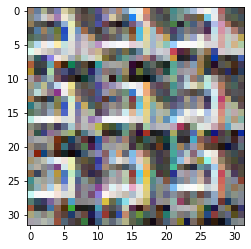

In [15]:
# TRY TO SEE IF M IS BEING CONSTRUCTED PROPERLY BY PLOTTING THE IMAGES AFTER M IS CONSTRUCTED

image_rgb = train_images[1]
print(image_rgb.shape)

image_rgb = image_rgb.reshape(32, 32, 3)
print(image_rgb.shape)

plt.imshow(image_rgb)
plt.show()


(3072,)
(32, 32, 3)


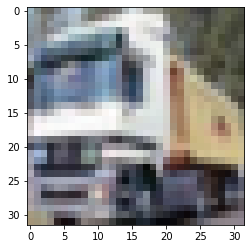

In [7]:
# TRY TO SEE IF M IS BEING CONSTRUCTED PROPERLY BY PLOTTING THE IMAGES AFTER M IS CONSTRUCTED

image_rgb = train_images[1]
print(image_rgb.shape)

image_rgb = np.transpose(np.reshape(image_rgb,(3, 32,32)), (1,2,0))
print(image_rgb.shape)

plt.imshow(image_rgb)
plt.show()




(3072,)
image_rgb_reshape.shape: (3, 32, 32)
image_rgb.shape: (32, 32, 3)
(32, 32, 3)


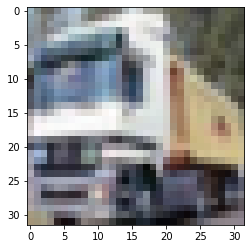

(3072,)
(3072,)
False
[0.6039216  0.49411765 0.4117647  ... 0.54509807 0.5568628  0.5647059 ]
[0.6039216  0.69411767 0.73333335 ... 0.56078434 0.52156866 0.5647059 ]


In [28]:
# TRY TO SEE IF M IS BEING CONSTRUCTED PROPERLY BY PLOTTING THE IMAGES AFTER M IS CONSTRUCTED

image_rgb = train_images[1]
print(image_rgb.shape)
image_rgb_3072_original = image_rgb

image_rgb_reshape = np.reshape(image_rgb,(3, 32,32))
print(f'image_rgb_reshape.shape: {image_rgb_reshape.shape}') #image_rgb_reshape.shape: (3, 32, 32)
image_rgb = np.transpose(image_rgb_reshape, (1,2,0))
print(f'image_rgb.shape: {image_rgb.shape}') #image_rgb.shape: (32, 32, 3)
#image_rgb = np.transpose(np.reshape(image_rgb,(3, 32,32)), (1,2,0))
print(image_rgb.shape)

plt.imshow(image_rgb)
plt.show()

image_rgb_3072_conv = image_rgb.reshape(3072)

print(image_rgb_3072_original.shape)
print(image_rgb_3072_conv.shape)
print((image_rgb_3072_original == image_rgb_3072_conv).all())

print(image_rgb_3072_original)
print(image_rgb_3072_conv)

In [16]:
print(train_images.shape)
sample_data = train_images[1]
print(sample_data.shape)
print(sample_data)
print(f'Magnitude of unnormalized images sample_data: {np.linalg.norm(sample_data)}')

print()
train_images_normalized = preprocessing.normalize(train_images, norm='l2')
print(train_images_normalized.shape)
print(train_images_normalized)
sample_data_normalized = train_images_normalized[1]
print(f'sample_data_normalized.shape: {sample_data_normalized.shape}')
print(f'Magnitude of the normalized/unit vector sample_data_normalized: {np.linalg.norm(sample_data_normalized)}')

(50000, 3072)
(3072,)
[0.6039216  0.49411765 0.4117647  ... 0.54509807 0.5568628  0.5647059 ]
Magnitude of unnormalized images sample_data: 31.232812881469727

(50000, 3072)
[[0.0091949  0.00670137 0.00779229 ... 0.0218184  0.01309104 0.01122089]
 [0.01933613 0.01582047 0.01318372 ... 0.01745274 0.01782942 0.01808053]
 [0.02927204 0.02904245 0.02904245 ... 0.00952776 0.00952776 0.00964255]
 ...
 [0.00488481 0.00558263 0.00586177 ... 0.01074657 0.00921135 0.00697829]
 [0.01906967 0.01876698 0.01866608 ... 0.01705172 0.01725351 0.01725351]
 [0.02867814 0.02955476 0.0293043  ... 0.02166514 0.02028759 0.02016236]]
sample_data_normalized.shape: (3072,)
Magnitude of the normalized/unit vector sample_data_normalized: 1.0000001192092896


In [17]:
train_data_cifar = train_images
train_data_cifar_normalized = train_images_normalized

print(train_data_cifar.shape)
print(train_data_cifar)
print()
print(train_data_cifar_normalized.shape)
print(train_data_cifar_normalized)
print()

sample_data = train_data_cifar[1]
print(sample_data.shape)
print(f'Magnitude of unnormalized images sample_data: {np.linalg.norm(sample_data)}')

sample_data_normalized = train_data_cifar_normalized[1]
print(f'sample_data_normalized.shape: {sample_data_normalized.shape}')
print(f'Magnitude of the normalized vector sample_data_normalized: {np.linalg.norm(sample_data_normalized)}')

(50000, 3072)
[[0.23137255 0.16862746 0.19607843 ... 0.54901963 0.32941177 0.28235295]
 [0.6039216  0.49411765 0.4117647  ... 0.54509807 0.5568628  0.5647059 ]
 [1.         0.99215686 0.99215686 ... 0.3254902  0.3254902  0.32941177]
 ...
 [0.13725491 0.15686275 0.16470589 ... 0.3019608  0.25882354 0.19607843]
 [0.7411765  0.7294118  0.7254902  ... 0.6627451  0.67058825 0.67058825]
 [0.8980392  0.9254902  0.91764706 ... 0.6784314  0.63529414 0.6313726 ]]

(50000, 3072)
[[0.0091949  0.00670137 0.00779229 ... 0.0218184  0.01309104 0.01122089]
 [0.01933613 0.01582047 0.01318372 ... 0.01745274 0.01782942 0.01808053]
 [0.02927204 0.02904245 0.02904245 ... 0.00952776 0.00952776 0.00964255]
 ...
 [0.00488481 0.00558263 0.00586177 ... 0.01074657 0.00921135 0.00697829]
 [0.01906967 0.01876698 0.01866608 ... 0.01705172 0.01725351 0.01725351]
 [0.02867814 0.02955476 0.0293043  ... 0.02166514 0.02028759 0.02016236]]

(3072,)
Magnitude of unnormalized images sample_data: 31.232812881469727
sample_da

In [ ]:
# Initialize variables required for the algorithm

learning_rate = 2e-2    # initial learning rate
Kx = 5
Ky = 5
n_hidden = 2000         # number of hidden units in hidden layer
mu = 0.0                # mean for gaussian distribution to initialize weights with
sigma = 1.0             # standard deviation for gaussian distribution to initialize weights with
n_epochs = 1000          # number of epochs
batch_size = 1000        # size of the minibatch
precision = 1e-30       # parameter to control numerical precision of weight updates

# From the paper
# p ∈ {2, 3, 4, 5}
# k ∈ {2, 3}
# delta ∈ {0, 0.1, 0.2, 0.3}
lebesgue_norm = 2.0                     # Lebesgue norm of the weights. p
rank = 2                                # ranking parameter, must be integer that is bigger or equal than 2. k
anti_hebbian_learning_strength = 0.1    # Strength of the anti-hebbian learning. delta

# p_5_k_2_delta_1

In [18]:
# RUN UNSUPERVISED 'BIO' LEARNING ALGORITHM for CIFAR

# p_2_k_2_delta_1

lebesgue_norm = 2.0                     # Lebesgue norm of the weights. p
rank = 2                                # ranking parameter, must be integer that is bigger or equal than 2. k
anti_hebbian_learning_strength = 0.1    # Strength of the anti-hebbian learning. delta

n_epochs = 1000         # number of epochs
minibatch_size = 1000   # size of the minibatch
learning_rate = 2e-2    # initial learning rate
n_hidden = 2000         # number of hidden units in hidden layer

mu = 0.0                # mean for gaussian distribution to initialize weights with
sigma = 1.0             # standard deviation for gaussian distribution to initialize weights with

precision = 1e-30       # parameter to control numerical precision of weight updates


# Calculates weights for data and provided number of hidden units (given other configuration)
print(f'train_data_cifar_normalized.shape: {train_data_cifar_normalized.shape}')
print(f'lebesgue_norm: {lebesgue_norm}')
print(f'rank: {rank}')
print(f'anti_hebbian_learning_strength: {anti_hebbian_learning_strength}')

weights_cifar = get_unsupervised_weights(train_data_cifar_normalized, n_hidden, n_epochs, minibatch_size, 
                                         learning_rate, precision, anti_hebbian_learning_strength, lebesgue_norm, 
                                         rank)

print(weights_cifar.shape)
print(weights_cifar)

# Keep backups of these weights
weights_cifar_backup = weights_cifar
weights_cifar_frozen = weights_cifar

# SAVE trained unsupervised weights TO FILE since it takes a long time to generate
print(weights_cifar.shape)
torch.save(weights_cifar, '/cs/scratch/aa295/weights_cifar_experiment_p_2_k_2_delta_1.pt')
print("SAVED")

train_data_cifar_normalized.shape: (50000, 3072)
lebesgue_norm: 2.0
rank: 2
anti_hebbian_learning_strength: 0.1
Starting unsupervised bio-plausible training
Epoch [1/1000]
Epoch [2/1000]
Epoch [3/1000]
Epoch [4/1000]
Epoch [5/1000]
Epoch [6/1000]
Epoch [7/1000]
Epoch [8/1000]
Epoch [9/1000]
Epoch [10/1000]
Epoch [11/1000]
Epoch [12/1000]
Epoch [13/1000]
Epoch [14/1000]
Epoch [15/1000]
Epoch [16/1000]
Epoch [17/1000]
Epoch [18/1000]
Epoch [19/1000]
Epoch [20/1000]
Epoch [21/1000]
Epoch [22/1000]
Epoch [23/1000]
Epoch [24/1000]
Epoch [25/1000]
Epoch [26/1000]
Epoch [27/1000]
Epoch [28/1000]
Epoch [29/1000]
Epoch [30/1000]
Epoch [31/1000]
Epoch [32/1000]
Epoch [33/1000]
Epoch [34/1000]
Epoch [35/1000]
Epoch [36/1000]
Epoch [37/1000]
Epoch [38/1000]
Epoch [39/1000]
Epoch [40/1000]
Epoch [41/1000]
Epoch [42/1000]
Epoch [43/1000]
Epoch [44/1000]
Epoch [45/1000]
Epoch [46/1000]
Epoch [47/1000]
Epoch [48/1000]
Epoch [49/1000]
Epoch [50/1000]
Epoch [51/1000]
Epoch [52/1000]
Epoch [53/1000]
Epoc

Epoch [481/1000]
Epoch [482/1000]
Epoch [483/1000]
Epoch [484/1000]
Epoch [485/1000]
Epoch [486/1000]
Epoch [487/1000]
Epoch [488/1000]
Epoch [489/1000]
Epoch [490/1000]
Epoch [491/1000]
Epoch [492/1000]
Epoch [493/1000]
Epoch [494/1000]
Epoch [495/1000]
Epoch [496/1000]
Epoch [497/1000]
Epoch [498/1000]
Epoch [499/1000]
Epoch [500/1000]
Epoch [501/1000]
Epoch [502/1000]
Epoch [503/1000]
Epoch [504/1000]
Epoch [505/1000]
Epoch [506/1000]
Epoch [507/1000]
Epoch [508/1000]
Epoch [509/1000]
Epoch [510/1000]
Epoch [511/1000]
Epoch [512/1000]
Epoch [513/1000]
Epoch [514/1000]
Epoch [515/1000]
Epoch [516/1000]
Epoch [517/1000]
Epoch [518/1000]
Epoch [519/1000]
Epoch [520/1000]
Epoch [521/1000]
Epoch [522/1000]
Epoch [523/1000]
Epoch [524/1000]
Epoch [525/1000]
Epoch [526/1000]
Epoch [527/1000]
Epoch [528/1000]
Epoch [529/1000]
Epoch [530/1000]
Epoch [531/1000]
Epoch [532/1000]
Epoch [533/1000]
Epoch [534/1000]
Epoch [535/1000]
Epoch [536/1000]
Epoch [537/1000]
Epoch [538/1000]
Epoch [539/100

Epoch [963/1000]
Epoch [964/1000]
Epoch [965/1000]
Epoch [966/1000]
Epoch [967/1000]
Epoch [968/1000]
Epoch [969/1000]
Epoch [970/1000]
Epoch [971/1000]
Epoch [972/1000]
Epoch [973/1000]
Epoch [974/1000]
Epoch [975/1000]
Epoch [976/1000]
Epoch [977/1000]
Epoch [978/1000]
Epoch [979/1000]
Epoch [980/1000]
Epoch [981/1000]
Epoch [982/1000]
Epoch [983/1000]
Epoch [984/1000]
Epoch [985/1000]
Epoch [986/1000]
Epoch [987/1000]
Epoch [988/1000]
Epoch [989/1000]
Epoch [990/1000]
Epoch [991/1000]
Epoch [992/1000]
Epoch [993/1000]
Epoch [994/1000]
Epoch [995/1000]
Epoch [996/1000]
Epoch [997/1000]
Epoch [998/1000]
Epoch [999/1000]
Epoch [1000/1000]
Completed unsupervised bio-plausible training
torch.Size([2000, 3072])
tensor([[0.0102, 0.0101, 0.0094,  ..., 0.0290, 0.0288, 0.0286],
        [0.0217, 0.0231, 0.0228,  ..., 0.0203, 0.0198, 0.0194],
        [0.0168, 0.0169, 0.0175,  ..., 0.0161, 0.0158, 0.0148],
        ...,
        [0.0067, 0.0142, 0.0153,  ..., 0.0012, 0.0012, 0.0011],
        [0.00

In [38]:
# SAVE trained unsupervised weights TO FILE since it takes a long time to generate
print(weights_cifar.shape)
torch.save(weights_cifar, '/cs/scratch/aa295/weights_cifar_experiment_p_2_k_2_delta_1.pt')
print("SAVED")

torch.Size([2000, 3072])
SAVED


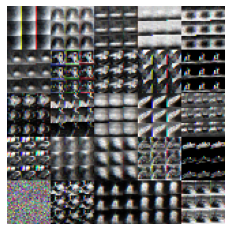

In [39]:
# Provided by Dmitry Krotov for my usage

# Here is a python function that we used for plotting these weights. 
# It has 4 inputs: 
#     1) the matrix of synapses (number of hidden units by the number of pixels*number of channels), 
#     2) Kx and Ky are the number of filters per row and column in the display (5 by 5 in Fig7), 
#     3) and the size of the individual filters Win (32 pixels for CIFAR-10 if you are doing the entire image). 

def draw_weights(synapses, Kx, Ky, Win):
    plt.clf()
    yy=0
    HM=np.zeros((Win*Kx,Win*Ky,3))
    for y in range(Ky):
        for x in range(Kx):
            disp=synapses[yy,:].reshape(Win,Win,3)
            #disp=synapses[:,yy].reshape(Win,Win,3)
            HM[y*Win:(y+1)*Win,x*Win:(x+1)*Win,:]=np.true_divide(disp-np.amin(disp),np.amax(disp)-np.amin(disp))
            yy += 1
    plt.imshow(HM,cmap='bwr')
    plt.axis('off')
    #fig.canvas.draw()  
    
#%matplotlib inline
#%matplotlib notebook
#fig=plt.figure(figsize=(6,5))

Kx = 5
Ky = 5
draw_weights(weights_cifar.cpu().numpy(), Kx, Ky, 32)


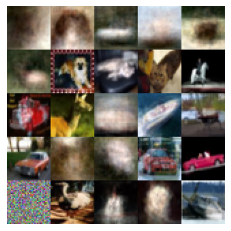

In [44]:
# Provided by Dmitry Krotov for my usage

# Here is a python function that we used for plotting these weights. 
# It has 4 inputs: 
#     1) the matrix of synapses (number of hidden units by the number of pixels*number of channels), 
#     2) Kx and Ky are the number of filters per row and column in the display (5 by 5 in Fig7), 
#     3) and the size of the individual filters Win (32 pixels for CIFAR-10 if you are doing the entire image). 

def draw_weights(synapses, Kx, Ky, Win):
    plt.clf()
    yy=0
    HM=np.zeros((Win*Kx,Win*Ky,3))
    for y in range(Ky):
        for x in range(Kx):
            #print(synapses.shape)
            #print(synapses[:,yy].shape)
            #print(synapses[yy,:].shape)
            #disp=synapses[yy,:].reshape(Win,Win,3)
            #disp=synapses[:,yy].reshape(Win,Win,3)
            disp=synapses[yy,:].reshape(3,Win,Win)
            #print(f'disp.shape: {disp.shape}')
            
            disp_rgb = np.transpose(disp, (1,2,0))
            #print(f'disp_rgb.shape: {disp_rgb.shape}')
            
            HM[y*Win:(y+1)*Win,x*Win:(x+1)*Win,:]=np.true_divide(disp_rgb-np.amin(disp_rgb),np.amax(disp_rgb)-np.amin(disp_rgb))
            #HM[y*Win:(y+1)*Win,x*Win:(x+1)*Win,:]=np.true_divide(disp-np.amin(disp),np.amax(disp)-np.amin(disp))
            yy += 1
    plt.imshow(HM,cmap='bwr')
    plt.axis('off')
    #fig.canvas.draw()  
    
#%matplotlib inline
#%matplotlib notebook
#fig=plt.figure(figsize=(6,5))

Kx = 5
Ky = 5
draw_weights(weights_cifar.cpu().numpy(), Kx, Ky, 32)


In [ ]:
# SUPERVISED COMPONENT

In [45]:
# DEFINE BioClassifier AND BioLoss CLASSES TO PERFORM BIO-PLAUSIBLE LEARNING

# REFERENCED FROM https://github.com/gatapia/unsupervised_bio_classifier

class BioCell(nn.Module):
    def __init__(self, Wui, beta, out_features):
        # Wui is the unsupervised pretrained weight matrix of shape: (2000, 28*28)
        
        super().__init__()
        # TODO: Does this need to be transposed here?
        # Answer: NO! Because we are using F.linear in the forward pass rather than multiplying directly ourselves.
        # F.linear does the transpose internally.
        self.Wui = Wui
        self.beta = beta
        self.supervised = nn.Linear(Wui.shape[0], out_features, bias=False)
        
    def forward(self, vi):
        Wui_vi = F.linear(vi, self.Wui, None)
        # Using basic RELU 
        hu = F.relu(Wui_vi)
        Sau = self.supervised(hu)
        ca = torch.tanh(self.beta * Sau)
        return ca

    
class BioCell2(nn.Module):
    def __init__(self, Wui, beta=0.1, out_features=10):
        # Wui is the unsupervised pretrained weight matrix of shape: (2000, 28*28)
        
        super().__init__()
        self.Wui = Wui.transpose(0, 1) # (768, 2000)
        self.beta = beta
        self.supervised = nn.Linear(Wui.shape[0], out_features, bias=False)
        
    def forward(self, vi):        
        # Different from BioCell where we do matmul here directly rather than using nn.Linear to accomplish the same.
        Wui_vi = torch.matmul(vi, self.Wui)
        # Using basic RELU 
        hu = F.relu(Wui_vi)
        Sau = self.supervised(hu)
        ca = torch.tanh(self.beta * Sau)
        return ca


class BioCell3(nn.Module):
    def __init__(self, Wui, n=4.5, beta=.01, out_features=10):
        # Wui is the unsupervised pretrained weight matrix of shape: (2000, 28*28)
        
        super().__init__()
        self.Wui = Wui.transpose(0, 1) # (768, 2000)
        self.n = n
        self.beta = beta
        # Below can be renamed to self.supervised to be similar to previous cells
        self.Sau = nn.Linear(Wui.shape[0], out_features, bias=False)
        
    def forward(self, vᵢ):
        # vᵢ = vᵢ.view(-1, 28, 28).transpose(1, 2).contiguous().view(-1, 28*28) # change vᵢ to be HxW for testing
        Wui_vi = torch.matmul(vi, self.Wui)
        # Using custom RELU as in the paper
        hu = F.relu(Wui_vi) ** self.n
        Sau_hu = self.Sau(hu)
        ca = torch.tanh(self.beta * Sau_hu)
        return ca

    
class BioLoss(nn.Module):
    def __init__(self, m=6):
        super().__init__()
        self.m = m

    # According to the hidden units paper, c = predictions, t = actual labels
    def forward(self, c, t):
        t_ohe = torch.eye(10, dtype=torch.float, device='cuda')[t]
        t_ohe[t_ohe==0] = -1.        
        loss = (c - t_ohe).abs() ** self.m
        return loss.sum()

    
class BioClassifier(nn.Module):
    def __init__(self, bio):
        super().__init__()
        self.bio = bio

    def forward(self, vi):
        ca = self.bio(vi)
        return F.log_softmax(ca, dim=-1)



In [46]:
# 0) Hyperparameters for supervised component of biological network
minibatch_size = 10
m = 6 # Used in BioLoss
n = 10 # Used in BioCell3
n_supervised_epochs = 500
supervised_learning_rate = 0.004 # for 100 epochs. Then halfed every 50 epochs.
beta = 0.1


# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
transform = transforms.Compose([transforms.ToTensor()])

print("Prepare CIFAR data...")
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=minibatch_size, 
                                           shuffle=False)
                                           #shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=minibatch_size, 
                                          shuffle=False)

print("Completed preparing CIFAR data.")


# 1) Design and init model
model = BioClassifier(BioCell3(weights_cifar, n=n, beta=beta, out_features=10)).to(device)


# 2) Construct loss and optimizer
criterion = BioLoss(m=m)
optimizer = torch.optim.Adam(model.parameters(), lr=supervised_learning_rate) 


# 3) Train the model - training loop
n_total_steps = len(train_loader)

print(f'n_total_steps per epoch: {n_total_steps}')
print(f'n_supervised_epochs: {n_supervised_epochs}')
print(f'batch_size: {minibatch_size}')

print('Start training...')
for epoch in range(n_supervised_epochs):
    
    if epoch == 100:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.002 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 150:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.001 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 200:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.0005 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 250:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.0002 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 300:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.0001 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 350:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.00005 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 400:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.00002 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 450:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.00001 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    
    for i, (images, labels) in enumerate(train_loader):
        
        # origin images shape: [100, 3, 32, 32]
        # resized: [100, 3072]
        #print(images.shape)
        
        images = images.reshape(-1, 32*32*3).to(device)
        labels = labels.to(device)
        
        #print(images.shape)
        #print(labels.shape)
        
        # PreProcessing
        # NORMALIZE EACH IMAGE to unit vector
        
        # NORMALIZATION with Numpy
        images_normalized = preprocessing.normalize(images.cpu().numpy(), norm='l2')
        images_normalized = torch.from_numpy(images_normalized).to(device)
        
        # predict = forward pass
        outputs = model(images_normalized)

        # calculate loss
        loss = criterion(outputs, labels)

        # backward pass to calculate gradients
        loss.backward()

        # update weights
        optimizer.step()

        # zero autograd .grad after updating
        optimizer.zero_grad()
        
        if (i+1) % 1000 == 0:
            print (f'Epoch [{epoch+1}/{n_supervised_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Completed training.')



# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
print("Testing the model...")
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 3*32*32).to(device)
        labels = labels.to(device)
        
        # PreProcessing
        # NORMALIZE EACH IMAGE to unit vector
        # NORMALIZATION with Numpy
        images_normalized = preprocessing.normalize(images.cpu().numpy(), norm='l2')
        images_normalized = torch.from_numpy(images_normalized).to(device)

        outputs = model(images_normalized)
        
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Prepare CIFAR data...
Files already downloaded and verified
Files already downloaded and verified
Completed preparing CIFAR data.
n_total_steps per epoch: 5000
n_supervised_epochs: 500
batch_size: 10
Start training...
Epoch [1/500], Step [1000/5000], Loss: 11332.9561
Epoch [1/500], Step [2000/5000], Loss: 10678.0205
Epoch [1/500], Step [3000/5000], Loss: 9737.2266
Epoch [1/500], Step [4000/5000], Loss: 11566.1445
Epoch [1/500], Step [5000/5000], Loss: 15440.1562
Epoch [2/500], Step [1000/5000], Loss: 12428.9023
Epoch [2/500], Step [2000/5000], Loss: 9287.3877
Epoch [2/500], Step [3000/5000], Loss: 9323.6211
Epoch [2/500], Step [4000/5000], Loss: 11575.2783
Epoch [2/500], Step [5000/5000], Loss: 15226.5947
Epoch [3/500], Step [1000/5000], Loss: 12449.2695
Epoch [3/500], Step [2000/5000], Loss: 8692.9209
Epoch [3/500], Step [3000/5000], Loss: 9078.1055
Epoch [3/500], Step [4000/5000], Loss: 11634.0938
Epoch [3/500], Step [5000/5000], Loss: 15067.5039
Epoch [4/500], Step [1000/5000], Loss

Epoch [32/500], Step [5000/5000], Loss: 13413.2500
Epoch [33/500], Step [1000/5000], Loss: 9753.9043
Epoch [33/500], Step [2000/5000], Loss: 7127.9941
Epoch [33/500], Step [3000/5000], Loss: 8265.7090
Epoch [33/500], Step [4000/5000], Loss: 11021.0146
Epoch [33/500], Step [5000/5000], Loss: 13395.2910
Epoch [34/500], Step [1000/5000], Loss: 9708.1133
Epoch [34/500], Step [2000/5000], Loss: 7113.0137
Epoch [34/500], Step [3000/5000], Loss: 8263.8340
Epoch [34/500], Step [4000/5000], Loss: 11009.2773
Epoch [34/500], Step [5000/5000], Loss: 13378.0859
Epoch [35/500], Step [1000/5000], Loss: 9663.9814
Epoch [35/500], Step [2000/5000], Loss: 7098.3667
Epoch [35/500], Step [3000/5000], Loss: 8262.1035
Epoch [35/500], Step [4000/5000], Loss: 10998.1387
Epoch [35/500], Step [5000/5000], Loss: 13361.5801
Epoch [36/500], Step [1000/5000], Loss: 9621.4004
Epoch [36/500], Step [2000/5000], Loss: 7084.0376
Epoch [36/500], Step [3000/5000], Loss: 8260.5059
Epoch [36/500], Step [4000/5000], Loss: 109

Epoch [65/500], Step [3000/5000], Loss: 8235.3340
Epoch [65/500], Step [4000/5000], Loss: 10834.5654
Epoch [65/500], Step [5000/5000], Loss: 13035.0977
Epoch [66/500], Step [1000/5000], Loss: 8781.0527
Epoch [66/500], Step [2000/5000], Loss: 6752.2256
Epoch [66/500], Step [3000/5000], Loss: 8234.6768
Epoch [66/500], Step [4000/5000], Loss: 10832.6016
Epoch [66/500], Step [5000/5000], Loss: 13027.2451
Epoch [67/500], Step [1000/5000], Loss: 8761.9062
Epoch [67/500], Step [2000/5000], Loss: 6743.5518
Epoch [67/500], Step [3000/5000], Loss: 8234.0244
Epoch [67/500], Step [4000/5000], Loss: 10830.7734
Epoch [67/500], Step [5000/5000], Loss: 13019.5020
Epoch [68/500], Step [1000/5000], Loss: 8743.1152
Epoch [68/500], Step [2000/5000], Loss: 6735.0005
Epoch [68/500], Step [3000/5000], Loss: 8233.3701
Epoch [68/500], Step [4000/5000], Loss: 10829.0762
Epoch [68/500], Step [5000/5000], Loss: 13011.8682
Epoch [69/500], Step [1000/5000], Loss: 8724.6641
Epoch [69/500], Step [2000/5000], Loss: 67

Epoch [98/500], Step [1000/5000], Loss: 8301.8301
Epoch [98/500], Step [2000/5000], Loss: 6523.8540
Epoch [98/500], Step [3000/5000], Loss: 8213.7646
Epoch [98/500], Step [4000/5000], Loss: 10819.7168
Epoch [98/500], Step [5000/5000], Loss: 12820.9248
Epoch [99/500], Step [1000/5000], Loss: 8290.1846
Epoch [99/500], Step [2000/5000], Loss: 6518.0576
Epoch [99/500], Step [3000/5000], Loss: 8213.1191
Epoch [99/500], Step [4000/5000], Loss: 10820.3076
Epoch [99/500], Step [5000/5000], Loss: 12815.5469
Epoch [100/500], Step [1000/5000], Loss: 8278.6855
Epoch [100/500], Step [2000/5000], Loss: 6512.3291
Epoch [100/500], Step [3000/5000], Loss: 8212.4668
Epoch [100/500], Step [4000/5000], Loss: 10820.9473
Epoch [100/500], Step [5000/5000], Loss: 12810.2168
Epoch:  100 , param_group[lr] before:  0.004
Epoch:  100 , param_group[lr] after:  0.002
Epoch [101/500], Step [1000/5000], Loss: 8332.9551
Epoch [101/500], Step [2000/5000], Loss: 6622.8823
Epoch [101/500], Step [3000/5000], Loss: 7967.79

Epoch [129/500], Step [4000/5000], Loss: 11073.4023
Epoch [129/500], Step [5000/5000], Loss: 12685.4287
Epoch [130/500], Step [1000/5000], Loss: 8009.4976
Epoch [130/500], Step [2000/5000], Loss: 6580.9448
Epoch [130/500], Step [3000/5000], Loss: 7941.8047
Epoch [130/500], Step [4000/5000], Loss: 11073.6523
Epoch [130/500], Step [5000/5000], Loss: 12682.4316
Epoch [131/500], Step [1000/5000], Loss: 8004.1851
Epoch [131/500], Step [2000/5000], Loss: 6579.1074
Epoch [131/500], Step [3000/5000], Loss: 7940.7456
Epoch [131/500], Step [4000/5000], Loss: 11073.9385
Epoch [131/500], Step [5000/5000], Loss: 12679.4434
Epoch [132/500], Step [1000/5000], Loss: 7998.9277
Epoch [132/500], Step [2000/5000], Loss: 6577.2900
Epoch [132/500], Step [3000/5000], Loss: 7939.6880
Epoch [132/500], Step [4000/5000], Loss: 11074.2383
Epoch [132/500], Step [5000/5000], Loss: 12676.4736
Epoch [133/500], Step [1000/5000], Loss: 7993.7139
Epoch [133/500], Step [2000/5000], Loss: 6575.4917
Epoch [133/500], Step [

Epoch [161/500], Step [2000/5000], Loss: 6711.6758
Epoch [161/500], Step [3000/5000], Loss: 7837.7793
Epoch [161/500], Step [4000/5000], Loss: 11009.7842
Epoch [161/500], Step [5000/5000], Loss: 11832.8652
Epoch [162/500], Step [1000/5000], Loss: 7803.0542
Epoch [162/500], Step [2000/5000], Loss: 6711.2480
Epoch [162/500], Step [3000/5000], Loss: 7837.7964
Epoch [162/500], Step [4000/5000], Loss: 11008.3145
Epoch [162/500], Step [5000/5000], Loss: 11830.1621
Epoch [163/500], Step [1000/5000], Loss: 7799.4922
Epoch [163/500], Step [2000/5000], Loss: 6710.7676
Epoch [163/500], Step [3000/5000], Loss: 7837.7725
Epoch [163/500], Step [4000/5000], Loss: 11006.9902
Epoch [163/500], Step [5000/5000], Loss: 11827.6309
Epoch [164/500], Step [1000/5000], Loss: 7796.0879
Epoch [164/500], Step [2000/5000], Loss: 6710.2471
Epoch [164/500], Step [3000/5000], Loss: 7837.6992
Epoch [164/500], Step [4000/5000], Loss: 11005.7930
Epoch [164/500], Step [5000/5000], Loss: 11825.2412
Epoch [165/500], Step [

Epoch [193/500], Step [2000/5000], Loss: 6693.1724
Epoch [193/500], Step [3000/5000], Loss: 7824.5410
Epoch [193/500], Step [4000/5000], Loss: 10997.8750
Epoch [193/500], Step [5000/5000], Loss: 11779.9355
Epoch [194/500], Step [1000/5000], Loss: 7718.2363
Epoch [194/500], Step [2000/5000], Loss: 6692.6221
Epoch [194/500], Step [3000/5000], Loss: 7823.9233
Epoch [194/500], Step [4000/5000], Loss: 10997.9629
Epoch [194/500], Step [5000/5000], Loss: 11778.6621
Epoch [195/500], Step [1000/5000], Loss: 7715.9878
Epoch [195/500], Step [2000/5000], Loss: 6692.0752
Epoch [195/500], Step [3000/5000], Loss: 7823.3008
Epoch [195/500], Step [4000/5000], Loss: 10998.0576
Epoch [195/500], Step [5000/5000], Loss: 11777.3867
Epoch [196/500], Step [1000/5000], Loss: 7713.7549
Epoch [196/500], Step [2000/5000], Loss: 6691.5298
Epoch [196/500], Step [3000/5000], Loss: 7822.6748
Epoch [196/500], Step [4000/5000], Loss: 10998.1562
Epoch [196/500], Step [5000/5000], Loss: 11776.1172
Epoch [197/500], Step [

Epoch [224/500], Step [5000/5000], Loss: 11271.2148
Epoch [225/500], Step [1000/5000], Loss: 7581.2183
Epoch [225/500], Step [2000/5000], Loss: 6657.2603
Epoch [225/500], Step [3000/5000], Loss: 7763.2251
Epoch [225/500], Step [4000/5000], Loss: 10972.3945
Epoch [225/500], Step [5000/5000], Loss: 11270.3066
Epoch [226/500], Step [1000/5000], Loss: 7579.9521
Epoch [226/500], Step [2000/5000], Loss: 6657.1636
Epoch [226/500], Step [3000/5000], Loss: 7763.0205
Epoch [226/500], Step [4000/5000], Loss: 10972.0146
Epoch [226/500], Step [5000/5000], Loss: 11269.4121
Epoch [227/500], Step [1000/5000], Loss: 7578.6987
Epoch [227/500], Step [2000/5000], Loss: 6657.0610
Epoch [227/500], Step [3000/5000], Loss: 7762.8110
Epoch [227/500], Step [4000/5000], Loss: 10971.6572
Epoch [227/500], Step [5000/5000], Loss: 11268.5391
Epoch [228/500], Step [1000/5000], Loss: 7577.4614
Epoch [228/500], Step [2000/5000], Loss: 6656.9561
Epoch [228/500], Step [3000/5000], Loss: 7762.5972
Epoch [228/500], Step [4

Epoch [256/500], Step [3000/5000], Loss: 7723.3105
Epoch [256/500], Step [4000/5000], Loss: 11002.7402
Epoch [256/500], Step [5000/5000], Loss: 10969.8936
Epoch [257/500], Step [1000/5000], Loss: 7537.0283
Epoch [257/500], Step [2000/5000], Loss: 6558.1191
Epoch [257/500], Step [3000/5000], Loss: 7722.7812
Epoch [257/500], Step [4000/5000], Loss: 11002.3662
Epoch [257/500], Step [5000/5000], Loss: 10969.0234
Epoch [258/500], Step [1000/5000], Loss: 7535.9443
Epoch [258/500], Step [2000/5000], Loss: 6558.0615
Epoch [258/500], Step [3000/5000], Loss: 7722.3350
Epoch [258/500], Step [4000/5000], Loss: 11001.9971
Epoch [258/500], Step [5000/5000], Loss: 10968.2178
Epoch [259/500], Step [1000/5000], Loss: 7534.9185
Epoch [259/500], Step [2000/5000], Loss: 6558.0723
Epoch [259/500], Step [3000/5000], Loss: 7721.9585
Epoch [259/500], Step [4000/5000], Loss: 11001.6406
Epoch [259/500], Step [5000/5000], Loss: 10967.4570
Epoch [260/500], Step [1000/5000], Loss: 7533.9487
Epoch [260/500], Step [

Epoch [288/500], Step [3000/5000], Loss: 7716.6816
Epoch [288/500], Step [4000/5000], Loss: 10994.7324
Epoch [288/500], Step [5000/5000], Loss: 10952.8652
Epoch [289/500], Step [1000/5000], Loss: 7516.6968
Epoch [289/500], Step [2000/5000], Loss: 6561.0518
Epoch [289/500], Step [3000/5000], Loss: 7716.5352
Epoch [289/500], Step [4000/5000], Loss: 10994.5684
Epoch [289/500], Step [5000/5000], Loss: 10952.4824
Epoch [290/500], Step [1000/5000], Loss: 7516.2427
Epoch [290/500], Step [2000/5000], Loss: 6561.1079
Epoch [290/500], Step [3000/5000], Loss: 7716.3750
Epoch [290/500], Step [4000/5000], Loss: 10994.4102
Epoch [290/500], Step [5000/5000], Loss: 10952.0938
Epoch [291/500], Step [1000/5000], Loss: 7515.7930
Epoch [291/500], Step [2000/5000], Loss: 6561.1650
Epoch [291/500], Step [3000/5000], Loss: 7716.2266
Epoch [291/500], Step [4000/5000], Loss: 10994.2539
Epoch [291/500], Step [5000/5000], Loss: 10951.7100
Epoch [292/500], Step [1000/5000], Loss: 7515.3447
Epoch [292/500], Step [

Epoch [320/500], Step [1000/5000], Loss: 7520.5830
Epoch [320/500], Step [2000/5000], Loss: 6545.3213
Epoch [320/500], Step [3000/5000], Loss: 7676.4771
Epoch [320/500], Step [4000/5000], Loss: 10937.5723
Epoch [320/500], Step [5000/5000], Loss: 10877.6924
Epoch [321/500], Step [1000/5000], Loss: 7520.2788
Epoch [321/500], Step [2000/5000], Loss: 6545.3618
Epoch [321/500], Step [3000/5000], Loss: 7676.3530
Epoch [321/500], Step [4000/5000], Loss: 10937.5000
Epoch [321/500], Step [5000/5000], Loss: 10877.4150
Epoch [322/500], Step [1000/5000], Loss: 7519.9766
Epoch [322/500], Step [2000/5000], Loss: 6545.4058
Epoch [322/500], Step [3000/5000], Loss: 7676.2354
Epoch [322/500], Step [4000/5000], Loss: 10937.4297
Epoch [322/500], Step [5000/5000], Loss: 10877.1484
Epoch [323/500], Step [1000/5000], Loss: 7519.6836
Epoch [323/500], Step [2000/5000], Loss: 6545.4536
Epoch [323/500], Step [3000/5000], Loss: 7676.1265
Epoch [323/500], Step [4000/5000], Loss: 10937.3584
Epoch [323/500], Step [5

Epoch [351/500], Step [4000/5000], Loss: 10853.6367
Epoch [351/500], Step [5000/5000], Loss: 10828.5098
Epoch [352/500], Step [1000/5000], Loss: 7515.9746
Epoch [352/500], Step [2000/5000], Loss: 6565.7939
Epoch [352/500], Step [3000/5000], Loss: 7634.9663
Epoch [352/500], Step [4000/5000], Loss: 10853.3828
Epoch [352/500], Step [5000/5000], Loss: 10828.0156
Epoch [353/500], Step [1000/5000], Loss: 7515.9067
Epoch [353/500], Step [2000/5000], Loss: 6565.4248
Epoch [353/500], Step [3000/5000], Loss: 7635.3555
Epoch [353/500], Step [4000/5000], Loss: 10853.2607
Epoch [353/500], Step [5000/5000], Loss: 10827.7500
Epoch [354/500], Step [1000/5000], Loss: 7515.7812
Epoch [354/500], Step [2000/5000], Loss: 6565.2222
Epoch [354/500], Step [3000/5000], Loss: 7635.5010
Epoch [354/500], Step [4000/5000], Loss: 10853.2031
Epoch [354/500], Step [5000/5000], Loss: 10827.5723
Epoch [355/500], Step [1000/5000], Loss: 7515.6455
Epoch [355/500], Step [2000/5000], Loss: 6565.0859
Epoch [355/500], Step [

Epoch [383/500], Step [4000/5000], Loss: 10853.2705
Epoch [383/500], Step [5000/5000], Loss: 10823.7959
Epoch [384/500], Step [1000/5000], Loss: 7511.4893
Epoch [384/500], Step [2000/5000], Loss: 6564.8135
Epoch [384/500], Step [3000/5000], Loss: 7633.6694
Epoch [384/500], Step [4000/5000], Loss: 10853.2617
Epoch [384/500], Step [5000/5000], Loss: 10823.6738
Epoch [385/500], Step [1000/5000], Loss: 7511.3511
Epoch [385/500], Step [2000/5000], Loss: 6564.8350
Epoch [385/500], Step [3000/5000], Loss: 7633.6152
Epoch [385/500], Step [4000/5000], Loss: 10853.2451
Epoch [385/500], Step [5000/5000], Loss: 10823.5469
Epoch [386/500], Step [1000/5000], Loss: 7511.2168
Epoch [386/500], Step [2000/5000], Loss: 6564.8643
Epoch [386/500], Step [3000/5000], Loss: 7633.5601
Epoch [386/500], Step [4000/5000], Loss: 10853.2344
Epoch [386/500], Step [5000/5000], Loss: 10823.4199
Epoch [387/500], Step [1000/5000], Loss: 7511.0815
Epoch [387/500], Step [2000/5000], Loss: 6564.8906
Epoch [387/500], Step [

Epoch [415/500], Step [2000/5000], Loss: 6585.9497
Epoch [415/500], Step [3000/5000], Loss: 7595.9717
Epoch [415/500], Step [4000/5000], Loss: 10800.0713
Epoch [415/500], Step [5000/5000], Loss: 10747.5576
Epoch [416/500], Step [1000/5000], Loss: 7484.7612
Epoch [416/500], Step [2000/5000], Loss: 6585.9331
Epoch [416/500], Step [3000/5000], Loss: 7595.9775
Epoch [416/500], Step [4000/5000], Loss: 10800.0957
Epoch [416/500], Step [5000/5000], Loss: 10747.5137
Epoch [417/500], Step [1000/5000], Loss: 7484.7339
Epoch [417/500], Step [2000/5000], Loss: 6585.9204
Epoch [417/500], Step [3000/5000], Loss: 7595.9761
Epoch [417/500], Step [4000/5000], Loss: 10800.1270
Epoch [417/500], Step [5000/5000], Loss: 10747.4746
Epoch [418/500], Step [1000/5000], Loss: 7484.6968
Epoch [418/500], Step [2000/5000], Loss: 6585.9092
Epoch [418/500], Step [3000/5000], Loss: 7595.9736
Epoch [418/500], Step [4000/5000], Loss: 10800.1582
Epoch [418/500], Step [5000/5000], Loss: 10747.4346
Epoch [419/500], Step [

Epoch [447/500], Step [2000/5000], Loss: 6585.9678
Epoch [447/500], Step [3000/5000], Loss: 7595.6313
Epoch [447/500], Step [4000/5000], Loss: 10800.5859
Epoch [447/500], Step [5000/5000], Loss: 10746.2793
Epoch [448/500], Step [1000/5000], Loss: 7483.5498
Epoch [448/500], Step [2000/5000], Loss: 6585.9746
Epoch [448/500], Step [3000/5000], Loss: 7595.6152
Epoch [448/500], Step [4000/5000], Loss: 10800.5879
Epoch [448/500], Step [5000/5000], Loss: 10746.2344
Epoch [449/500], Step [1000/5000], Loss: 7483.5039
Epoch [449/500], Step [2000/5000], Loss: 6585.9814
Epoch [449/500], Step [3000/5000], Loss: 7595.6025
Epoch [449/500], Step [4000/5000], Loss: 10800.5977
Epoch [449/500], Step [5000/5000], Loss: 10746.2002
Epoch [450/500], Step [1000/5000], Loss: 7483.4604
Epoch [450/500], Step [2000/5000], Loss: 6585.9927
Epoch [450/500], Step [3000/5000], Loss: 7595.5913
Epoch [450/500], Step [4000/5000], Loss: 10800.6045
Epoch [450/500], Step [5000/5000], Loss: 10746.1602
Epoch:  450 , param_gro

Epoch [478/500], Step [5000/5000], Loss: 10715.9053
Epoch [479/500], Step [1000/5000], Loss: 7461.1670
Epoch [479/500], Step [2000/5000], Loss: 6591.1426
Epoch [479/500], Step [3000/5000], Loss: 7581.8979
Epoch [479/500], Step [4000/5000], Loss: 10792.6426
Epoch [479/500], Step [5000/5000], Loss: 10715.8984
Epoch [480/500], Step [1000/5000], Loss: 7461.1514
Epoch [480/500], Step [2000/5000], Loss: 6591.1416
Epoch [480/500], Step [3000/5000], Loss: 7581.8965
Epoch [480/500], Step [4000/5000], Loss: 10792.6455
Epoch [480/500], Step [5000/5000], Loss: 10715.8867
Epoch [481/500], Step [1000/5000], Loss: 7461.1406
Epoch [481/500], Step [2000/5000], Loss: 6591.1445
Epoch [481/500], Step [3000/5000], Loss: 7581.8975
Epoch [481/500], Step [4000/5000], Loss: 10792.6455
Epoch [481/500], Step [5000/5000], Loss: 10715.8828
Epoch [482/500], Step [1000/5000], Loss: 7461.1274
Epoch [482/500], Step [2000/5000], Loss: 6591.1465
Epoch [482/500], Step [3000/5000], Loss: 7581.8955
Epoch [482/500], Step [4

In [47]:
print(train_images.shape)
sample_data = train_images[1]
print(sample_data.shape)
print(sample_data)
print(f'Magnitude of unnormalized images sample_data: {np.linalg.norm(sample_data)}')

print()
train_images_normalized = preprocessing.normalize(train_images, norm='l2')
print(train_images_normalized.shape)
print(train_images_normalized)
sample_data_normalized = train_images_normalized[1]
print(f'sample_data_normalized.shape: {sample_data_normalized.shape}')
print(f'Magnitude of the normalized/unit vector sample_data_normalized: {np.linalg.norm(sample_data_normalized)}')

(50000, 3072)
(3072,)
[0.6039216  0.49411765 0.4117647  ... 0.54509807 0.5568628  0.5647059 ]
Magnitude of unnormalized images sample_data: 31.232812881469727

(50000, 3072)
[[0.0091949  0.00670137 0.00779229 ... 0.0218184  0.01309104 0.01122089]
 [0.01933613 0.01582047 0.01318372 ... 0.01745274 0.01782942 0.01808053]
 [0.02927204 0.02904245 0.02904245 ... 0.00952776 0.00952776 0.00964255]
 ...
 [0.00488481 0.00558263 0.00586177 ... 0.01074657 0.00921135 0.00697829]
 [0.01906967 0.01876698 0.01866608 ... 0.01705172 0.01725351 0.01725351]
 [0.02867814 0.02955476 0.0293043  ... 0.02166514 0.02028759 0.02016236]]
sample_data_normalized.shape: (3072,)
Magnitude of the normalized/unit vector sample_data_normalized: 1.0000001192092896


In [49]:
train_data = []
test_data = []

for i in range(len(train_images)):
    train_data.append([train_images[i], train_labels[i]])

for i in range(len(test_images)):
    test_data.append([test_images[i], test_labels[i]])
    
print(f'train_images.shape: {train_images.shape}')
print(f'train_labels.shape: {train_labels.shape}')
print(f'test_images.shape: {test_images.shape}')
print(f'test_labels.shape: {test_labels.shape}')


train_images.shape: (50000, 3072)
train_labels.shape: (50000, 10)
test_images.shape: (10000, 3072)
test_labels.shape: (10000, 10)


In [ ]:
# TODO Try with using the targets and labels I already have rather than the CIFAR10 library
# TODO lookup how to do that

# 0) Hyperparameters for supervised component of biological network
minibatch_size = 10
m = 6 # Used in BioLoss
n = 10 # Used in BioCell3
n_supervised_epochs = 500
supervised_learning_rate = 0.004 # for 100 epochs. Then halfed every 50 epochs.
beta = 0.1


# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class

print("Prepare CIFAR data...")

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=minibatch_size, 
                                           shuffle=False)
                                           #shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=minibatch_size, 
                                          shuffle=False)

print("Completed preparing CIFAR data.")


# 1) Design and init model
model = BioClassifier(BioCell3(weights_cifar, n=n, beta=beta, out_features=10)).to(device)


# 2) Construct loss and optimizer
criterion = BioLoss(m=m)
optimizer = torch.optim.Adam(model.parameters(), lr=supervised_learning_rate) 


# 3) Train the model - training loop
n_total_steps = len(train_loader)

print(f'n_total_steps per epoch: {n_total_steps}')
print(f'n_supervised_epochs: {n_supervised_epochs}')
print(f'batch_size: {minibatch_size}')

print('Start training...')
for epoch in range(n_supervised_epochs):
    
    if epoch == 100:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.002 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 150:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.001 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 200:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.0005 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 250:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.0002 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 300:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.0001 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 350:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.00005 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 400:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.00002 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 450:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.00001 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    
    for i, (images, labels) in enumerate(train_loader):
        
        # origin images shape: [100, 3, 32, 32]
        # resized: [100, 3072]
        #print(images.shape)
        
        images = images.reshape(-1, 32*32*3).to(device)
        labels = labels.to(device)
        
        #print(images.shape)
        #print(labels.shape)
        
        # PreProcessing
        # NORMALIZE EACH IMAGE to unit vector
        
        # NORMALIZATION with Numpy
        images_normalized = preprocessing.normalize(images.cpu().numpy(), norm='l2')
        images_normalized = torch.from_numpy(images_normalized).to(device)
        
        # predict = forward pass
        outputs = model(images_normalized)

        # calculate loss
        loss = criterion(outputs, labels)

        # backward pass to calculate gradients
        loss.backward()

        # update weights
        optimizer.step()

        # zero autograd .grad after updating
        optimizer.zero_grad()
        
        if (i+1) % 1000 == 0:
            print (f'Epoch [{epoch+1}/{n_supervised_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Completed training.')



# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
print("Testing the model...")
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 3*32*32).to(device)
        labels = labels.to(device)
        
        # PreProcessing
        # NORMALIZE EACH IMAGE to unit vector
        # NORMALIZATION with Numpy
        images_normalized = preprocessing.normalize(images.cpu().numpy(), norm='l2')
        images_normalized = torch.from_numpy(images_normalized).to(device)

        outputs = model(images_normalized)
        
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Prepare CIFAR data...
Completed preparing CIFAR data.
n_total_steps per epoch: 5000
n_supervised_epochs: 500
batch_size: 10
Start training...


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

Epoch [1/500], Step [1000/5000], Loss: 14282.8164


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

Epoch [1/500], Step [2000/5000], Loss: 13885.9414


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

Epoch [1/500], Step [3000/5000], Loss: 490.5184


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

Epoch [1/500], Step [4000/5000], Loss: 488.5099


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

Epoch [1/500], Step [5000/5000], Loss: 13502.1133


/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
/pytorch/aten/src/ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype

In [ ]:
print(train_images.shape)
sample_data = train_images[1]
print(sample_data.shape)
print(sample_data)
print(f'Magnitude of unnormalized images sample_data: {np.linalg.norm(sample_data)}')

print()
train_images_normalized = preprocessing.normalize(train_images, norm='l2')
print(train_images_normalized.shape)
print(train_images_normalized)
sample_data_normalized = train_images_normalized[1]
print(f'sample_data_normalized.shape: {sample_data_normalized.shape}')
print(f'Magnitude of the normalized/unit vector sample_data_normalized: {np.linalg.norm(sample_data_normalized)}')

print()
test_images_normalized = preprocessing.normalize(test_images, norm='l2')
print(test_images_normalized.shape)
print(test_images_normalized)
sample_data_normalized = test_images_normalized[1]
print(f'sample_data_normalized.shape: {sample_data_normalized.shape}')
print(f'Magnitude of the normalized/unit vector sample_data_normalized: {np.linalg.norm(sample_data_normalized)}')

In [ ]:
# NORMALIZED Test and Train to unit vectors

train_data = []
test_data = []

for i in range(len(train_images_normalized)):
    train_data.append([train_images_normalized[i], train_labels[i]])

for i in range(len(test_images_normalized)):
    test_data.append([test_images_normalized[i], test_labels[i]])
    
print(f'train_images_normalized.shape: {train_images_normalized.shape}')
print(f'train_labels.shape: {train_labels.shape}')
print(f'test_images_normalized.shape: {test_images_normalized.shape}')
print(f'test_labels.shape: {test_labels.shape}')
print()
print(f'train_data.shape: {train_data.shape}')
print(f'test_data.shape: {test_data.shape}')

In [ ]:
# TODO Try with using the targets and labels I already have rather than the CIFAR10 library
# TODO lookup how to do that
# No need to NORMALIZE the images here because that is done in the previous cell

# 0) Hyperparameters for supervised component of biological network
minibatch_size = 10
m = 6 # Used in BioLoss
n = 10 # Used in BioCell3
n_supervised_epochs = 500
supervised_learning_rate = 0.004 # for 100 epochs. Then halfed every 50 epochs.
beta = 0.1


# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class

print("Prepare CIFAR data...")

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_data, 
                                           batch_size=minibatch_size, 
                                           shuffle=False)
                                           #shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data, 
                                          batch_size=minibatch_size, 
                                          shuffle=False)

print("Completed preparing CIFAR data.")


# 1) Design and init model
model = BioClassifier(BioCell3(weights_cifar, n=n, beta=beta, out_features=10)).to(device)


# 2) Construct loss and optimizer
criterion = BioLoss(m=m)
optimizer = torch.optim.Adam(model.parameters(), lr=supervised_learning_rate) 


# 3) Train the model - training loop
n_total_steps = len(train_loader)

print(f'n_total_steps per epoch: {n_total_steps}')
print(f'n_supervised_epochs: {n_supervised_epochs}')
print(f'batch_size: {minibatch_size}')

print('Start training...')
for epoch in range(n_supervised_epochs):
    
    if epoch == 100:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.002 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 150:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.001 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 200:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.0005 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 250:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.0002 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 300:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.0001 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 350:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.00005 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 400:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.00002 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    elif epoch == 450:
        for param_group in optimizer.param_groups:
            print("Epoch: ", epoch, ", param_group[lr] before: ", param_group['lr'])
            # Half the learning rate
            param_group['lr'] = 0.00001 # param_group['lr']/2
            print("Epoch: ", epoch, ", param_group[lr] after: ", param_group['lr'])
    
    for i, (images, labels) in enumerate(train_loader):
        
        # origin images shape: [100, 3, 32, 32]
        # resized: [100, 3072]
        print(f'images.shape: {images.shape}')
        print(f'labels.shape: {labels.shape}')
        
        sample_data = images[1]
        print(sample_data.shape)
        print(sample_data)
        print(f'Magnitude of images sample_data: {np.linalg.norm(sample_data)}')
        
        images = images.reshape(-1, 32*32*3).to(device)
        labels = labels.to(device)
        
        print(f'images.shape after: {images.shape}')
        print(f'labels.shape after: {labels.shape}')
    
        
        # PreProcessing
        # NORMALIZE EACH IMAGE to unit vector
        
        # NORMALIZATION with Numpy
        #images_normalized = preprocessing.normalize(images.cpu().numpy(), norm='l2')
        #images_normalized = torch.from_numpy(images_normalized).to(device)
        
        # predict = forward pass
        outputs = model(images)

        # calculate loss
        loss = criterion(outputs, labels)

        # backward pass to calculate gradients
        loss.backward()

        # update weights
        optimizer.step()

        # zero autograd .grad after updating
        optimizer.zero_grad()
        
        if (i+1) % 1000 == 0:
            print (f'Epoch [{epoch+1}/{n_supervised_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Completed training.')



# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
print("Testing the model...")
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 3*32*32).to(device)
        labels = labels.to(device)
        
        # PreProcessing
        # NORMALIZE EACH IMAGE to unit vector
        # NORMALIZATION with Numpy
        images_normalized = preprocessing.normalize(images.cpu().numpy(), norm='l2')
        images_normalized = torch.from_numpy(images_normalized).to(device)

        outputs = model(images_normalized)
        
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')